<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/weatherAus_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [45]:
fulldata = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/weatherAUS.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [46]:
fulldata['RainToday'].replace({'No':0, 'Yes':1}, inplace=True)
fulldata['RainTomorrow'].replace({'No':0, 'Yes':1}, inplace=True)

In [3]:
fulldata['RainToday'].replace({'No':0, 'Yes':1}, inplace=True)
fulldata['RainTomorrow'].replace({'No':0, 'Yes':1}, inplace=True)

Text(0.5, 1.0, 'Distribution of RainTomorrow')

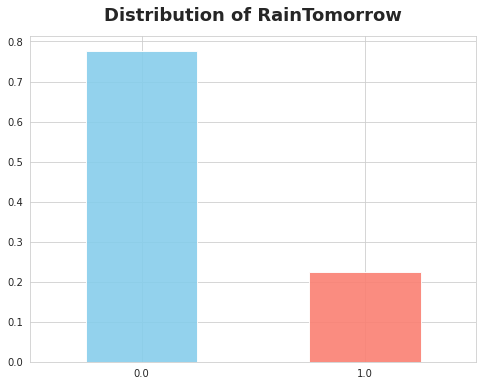

In [ ]:
fig = plt.figure(figsize=(8,6))
fulldata.RainTomorrow.value_counts(normalize=True).plot.bar(color=['skyblue', 'salmon'], alpha=.9, rot=0)
plt.title('Distribution of RainTomorrow', fontsize=18, fontweight='bold', pad=15)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

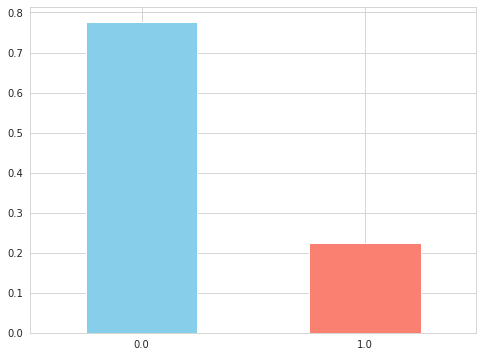

In [10]:
fig = plt.figure(figsize=(8,6))
fulldata['RainTomorrow'].value_counts(normalize=True).plot.bar(color=['skyblue', 'salmon'])
plt.xticks(rotation=360)

In [ ]:
from sklearn.utils import resample
## RainTomorrow 오버샘플링 하려고한다.

In [47]:
from sklearn.utils import resample

no = fulldata[fulldata.RainTomorrow == 0]
yes = fulldata[fulldata.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
data = pd.concat([no, yes_oversampled])

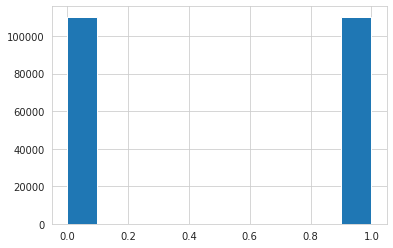

In [8]:
data.RainTomorrow.hist()

In [ ]:
no = fulldata[data.RainTomorrow == 0]
yes = fulldata[data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

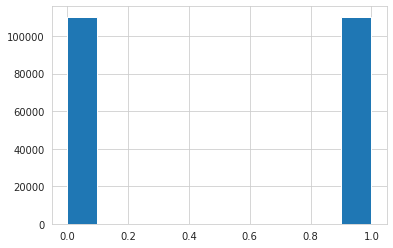

In [ ]:
oversampled.RainTomorrow.hist()

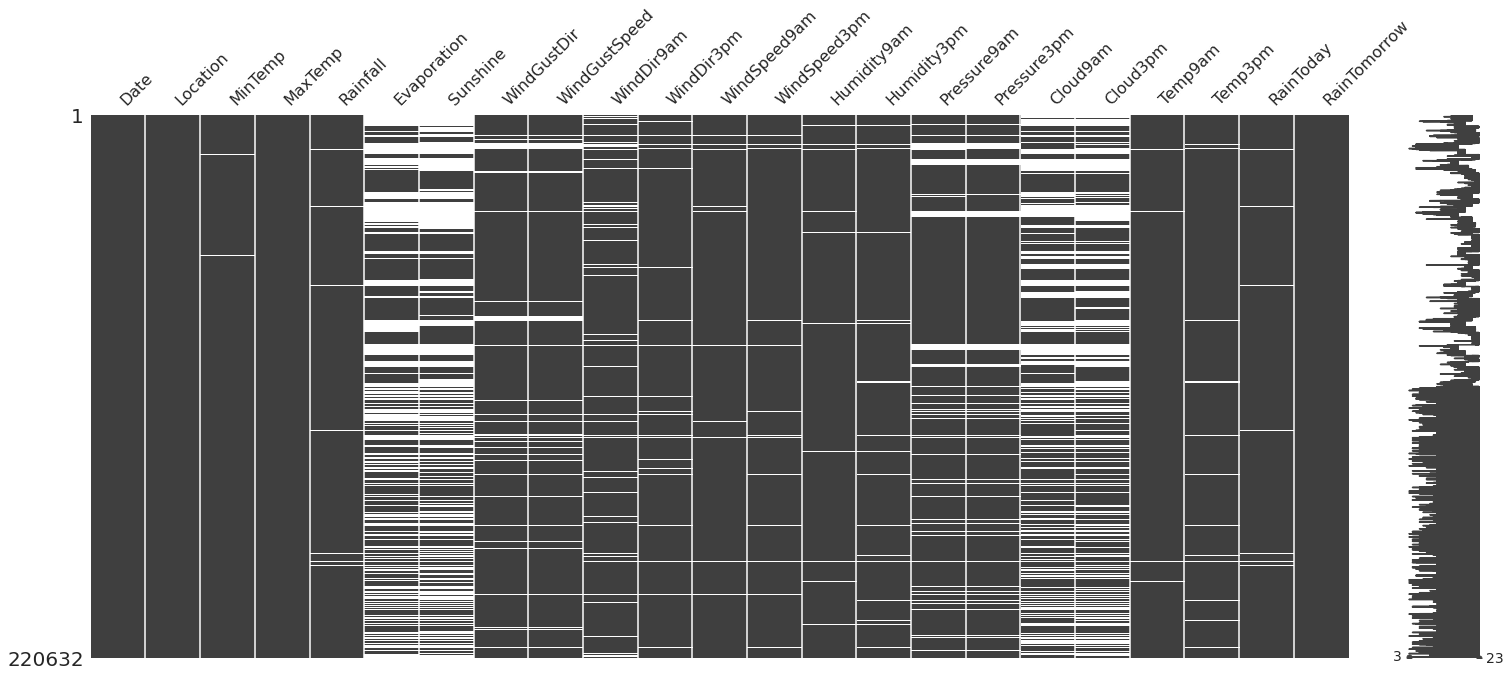

In [ ]:
import missingno as msno
msno.matrix(oversampled)

In [ ]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head()

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664
Pressure3pm,21746,0.098562


In [17]:
data.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [48]:
for i in data.select_dtypes(include=['object']).columns:
  data[i] = data[i].fillna(data[i].mode()[0])

In [19]:
data.isnull().sum()

Date                  0
Location              0
MinTemp            1941
MaxTemp            1414
Rainfall           5047
Evaporation       98760
Sunshine         108376
WindGustDir           0
WindGustSpeed     16616
WindDir9am            0
WindDir3pm            0
WindSpeed9am       2659
WindSpeed3pm       4856
Humidity9am        4103
Humidity3pm        7031
Pressure9am       23097
Pressure3pm       23110
Cloud9am          84698
Cloud3pm          89036
Temp9am            2547
Temp3pm            5522
RainToday          5047
RainTomorrow       3267
dtype: int64

In [ ]:
oversampled.select_dtypes(include=['object']).columns
## select_dtypes(include=[]) ==> 원하는 데이터타입 찾아주는것

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [10]:
data['Date'] = data['Date'].fillna(data['Date'].mode()[0])
data['Location'] = data['Location'].fillna(data['Location'].mode()[0])
data['WindGustDir'] = data['WindGustDir'].fillna(data['WindGustDir'].mode()[0])
data['WindDir9am'] = data['WindDir9am'].fillna(data['WindDir9am'].mode()[0])
data['WindDir3pm'] = data['WindDir3pm'].fillna(data['WindDir3pm'].mode()[0])

In [9]:
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])
## object타입은 mode로 채움

NameError: ignored

In [49]:
from sklearn.preprocessing import LabelEncoder

lencoders = {}
for i in data.select_dtypes(include=['object']).columns:
  lencoders[i] = LabelEncoder()
  data[i] = lencoders[i].fit_transform(data[i])

In [ ]:
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
  lencoders[col] = LabelEncoder()
  oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
## 결측치 제거 모듈

In [50]:
miceimputed = data.copy(deep=True)
mice_imputer = IterativeImputer()
miceimputed.iloc[:,:] = mice_imputer.fit_transform(data)

In [53]:
data = miceimputed

In [52]:
data.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

In [ ]:
miceimputed = oversampled.copy(deep=True)
mice_imputer = IterativeImputer()
miceimputed.iloc[:,:] = mice_imputer.fit_transform(oversampled)
## 결측치 제거

In [ ]:
miceimputed.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

In [25]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1531.000000
Location           25.000000
MinTemp             9.200000
MaxTemp            10.200000
Rainfall            2.600000
Evaporation         4.105717
Sunshine            5.919378
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        31.000000
Pressure9am         8.700000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.648675
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [ ]:
## 이상값 처리 -IQR * 1.5 ~ IQR * 1.5 밖에 있으면 이상값
Q1 = miceimputed.quantile(0.25)  ## 25%
Q3 = miceimputed.quantile(0.75)  ## 75%
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.120044
Sunshine            5.979485
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.684676
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [29]:
data[((data < (Q1 - 1.5*IQR)) | (data > (Q3 + 1.5*IQR))).any(axis=1)]
## 이것들이 이상값을 포함한 데이터들

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
18,414.0,2.0,11.200000,22.5,10.6,6.530438,10.712117,10.0,43.000000,15.0,12.0,24.0,17.0,47.000000,32.0,1009.400000,1009.700000,2.681393,2.000000,15.50000,21.0,1.0,0.0
44,440.0,2.0,17.400000,43.0,0.0,10.616860,14.828448,7.0,39.000000,10.0,11.0,7.0,17.0,40.000000,8.0,1011.600000,1006.900000,0.592753,1.215622,25.60000,41.5,0.0,0.0
60,456.0,2.0,22.300000,42.9,0.0,11.203004,13.325672,5.0,28.000000,2.0,9.0,9.0,11.0,37.000000,11.0,1014.600000,1010.200000,1.384007,1.784069,29.20000,41.2,0.0,0.0
61,457.0,2.0,22.000000,42.7,0.0,11.560466,12.679373,2.0,48.000000,2.0,12.0,4.0,4.0,33.000000,11.0,1014.200000,1010.500000,1.324556,2.044012,29.90000,42.0,0.0,0.0
62,458.0,2.0,28.000000,43.1,0.0,13.775745,11.826126,12.0,83.000000,9.0,0.0,15.0,9.0,27.000000,9.0,1012.500000,1008.700000,2.161585,2.453185,32.40000,41.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142917,2471.0,16.0,28.000000,40.4,0.0,9.400000,6.607722,8.0,81.000000,14.0,4.0,11.0,17.0,60.000000,26.0,1012.800000,1007.100000,4.000000,8.000000,31.80000,40.0,0.0,1.0
15531,851.0,24.0,18.029171,21.4,14.2,4.406422,1.275956,13.0,36.725378,9.0,9.0,19.0,6.0,81.000000,85.0,1014.093015,1013.052146,8.000000,8.000000,19.50000,19.9,1.0,1.0
138930,3255.0,3.0,22.300000,30.1,48.6,6.000000,4.048774,3.0,56.000000,6.0,7.0,24.0,24.0,99.000000,64.0,1000.100000,997.100000,8.000000,6.000000,22.40000,29.6,1.0,1.0
39707,596.0,45.0,11.400000,17.7,24.0,0.800000,2.100000,1.0,35.000000,1.0,2.0,13.0,20.0,97.000000,64.0,1028.700000,1026.100000,8.000000,7.000000,13.60000,17.2,1.0,1.0


In [99]:
data = data[~((data < (Q1 - 1.5*IQR)) | (data > (Q3 + 1.5*IQR))).any(axis=1)]

In [ ]:
miceimputed = miceimputed[~((miceimputed < (Q1 - 1.5*IQR))|
(miceimputed > (Q3 + 1.5*IQR))).any(axis=1)]
miceimputed.shape
## 이상값 처리 완료

(170669, 23)

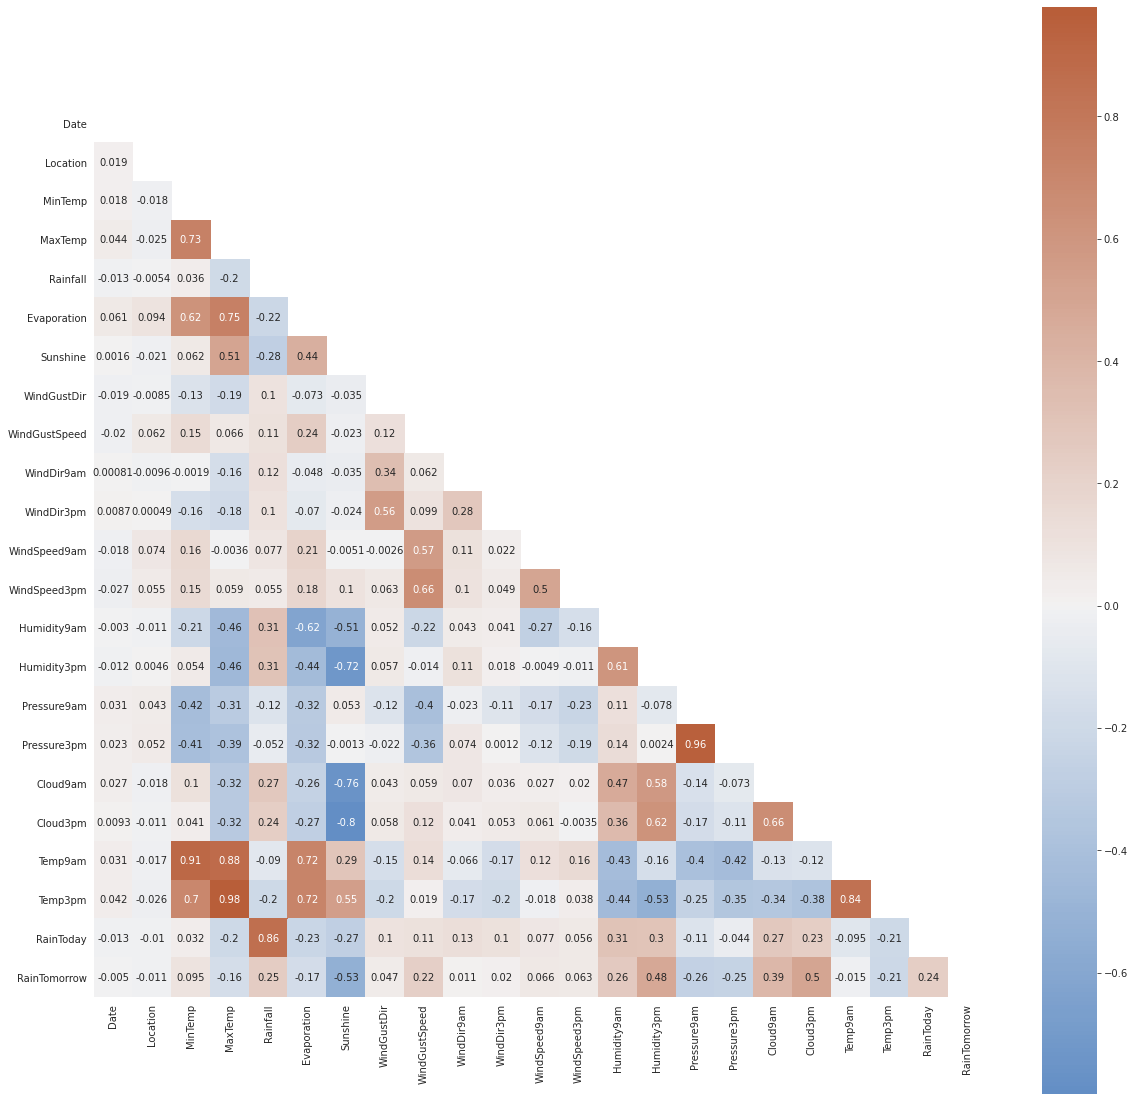

In [ ]:
mask = np.triu(np.ones_like(miceimputed.corr(), dtype=np.bool))
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(miceimputed.corr(), annot=True, cmap=sns.diverging_palette(250, 25, as_cmap=True), vmax=None, center=0, square=True, mask=mask)

In [71]:
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(data)
data = pd.DataFrame(r_scaler.transform(data), columns=data.columns)
data.head()
## 스케일링 완료(minimaxscaling)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0.115284,0.041667,0.539691,0.523629,0.021045,0.066521,0.492227,0.866667,0.279165,0.866667,0.933333,0.175198,0.275862,0.786159,0.506140,0.449587,0.4800,0.838396,0.481535,0.508439,0.522073,0.27817,0.303547
1,0.115575,0.041667,0.404966,0.565217,0.019459,0.065910,0.686356,0.933333,0.279165,0.400000,1.000000,0.055227,0.252874,0.653057,0.523540,0.497521,0.4912,0.347689,0.308210,0.514768,0.570058,0.27817,0.303547
2,0.115866,0.041667,0.528464,0.576560,0.019459,0.080183,0.724960,1.000000,0.293858,0.866667,1.000000,0.167700,0.298851,0.623479,0.552540,0.447934,0.5056,0.356135,0.260754,0.594937,0.548944,0.27817,0.303547
3,0.116157,0.041667,0.445384,0.620038,0.019459,0.068158,0.699462,0.266667,0.132236,0.600000,0.000000,0.107714,0.103448,0.657987,0.471339,0.613223,0.5712,0.309940,0.270069,0.533755,0.612284,0.27817,0.303547
4,0.116448,0.041667,0.631753,0.701323,0.022102,0.074039,0.410367,0.866667,0.257125,0.066667,0.466667,0.077721,0.229885,0.840386,0.569940,0.500826,0.4624,0.760340,0.726710,0.527426,0.673704,0.27817,0.303547


In [72]:
from sklearn.feature_selection import SelectKBest, chi2
X = data.loc[:, data.columns !='RainTomorrow']
Y = data['RainTomorrow']
selector = SelectKBest(chi2, k=10)
selector.fit(X,Y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

ValueError: ignored

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

X = miceimputed.drop('RainTomorrow', axis=1)
Y = miceimputed['RainTomorrow']
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=0))
selector.fit(X,Y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(RandomForestClassifier(n_estimators=100).fit(X,Y).feature_importances_)

['Sunshine', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
[0.03275395 0.02833954 0.03242857 0.03236553 0.02497738 0.03248613
 0.12873661 0.02081623 0.04110439 0.02180083 0.02161294 0.02162826
 0.02338384 0.0325682  0.11066192 0.04624377 0.06311484 0.06392741
 0.14225898 0.03170549 0.03434437 0.01274083]


In [54]:
x = data.drop(['RainTomorrow'], axis=1)
y = data['RainTomorrow']

In [57]:
from sklearn.preprocessing import robust_scale

x = robust_scale(x)
x =  pd.DataFrame(x, columns=x_train.columns)

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.25, random_state=12345)

In [ ]:
x = miceimputed.drop(['RainTomorrow'], axis=1)
y = miceimputed['RainTomorrow']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.25, random_state=12345)

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
## 여기는 이제 와서 스케일링하네...(robust쓰면 되자나...)

In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_auc_score, cohen_kappa_score
from sklearn.model_selection import GridSearchCV, cross_val_score

In [44]:
from sklearn.linear_model import LogisticRegression

param_lr = {'penalty':'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**param_lr)
model_lr.fit(x_train, y_train)
y_pred_lr = model_lr.predict(x_test)
print('Logistic Accuracy:', accuracy_score(y_test, y_pred_lr))

Logistic Accuracy: 0.8048877769317234


In [39]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import xgboost as xgb
import lightgbm as lgb

In [24]:
model_dectree = DecisionTreeClassifier(max_depth=100)
model_dectree.fit(x_train, y_train)
y_pred_dectree = model_dectree.predict(x_test)
print('DecisionTree Accuracy:', accuracy_score(y_test, y_pred_dectree))

DecisionTree Accuracy: 0.9242902208201893


In [59]:
model_rf = RandomForestClassifier(max_depth=150, n_jobs=-1)
model_rf.fit(x_train, y_train)
y_pred_rf = model_rf.predict(x_test)
print('RandomForest Accuracy:', accuracy_score(y_test, y_pred_rf))
print('RandomForest f1-score:', f1_score(y_test, y_pred_rf))
print('RandomForest AUC score:', roc_auc_score(y_test, y_pred_rf))
print('RandomForest Kappa score', cohen_kappa_score(y_test, y_pred_rf))
## 와... 결측치 그냥 iteractive imputer 하고 이상치만 제거했는데.. 이런값이

RandomForest Accuracy: 0.954621269806737
RandomForest f1-score: 0.9558281125915468
RandomForest AUC score: 0.9545516334388123
RandomForest Kappa score 0.9092292376489651


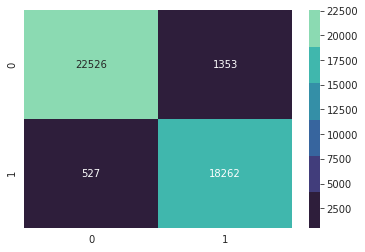

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap=sns.color_palette('mako'))

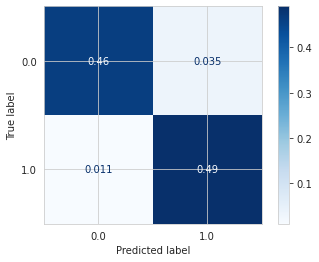

In [27]:
plot_confusion_matrix(model_rf, x_test, y_test, normalize='all', cmap=plt.cm.Blues)

In [60]:
model_xgb = xgb.XGBClassifier(max_depth=100, n_jobs=-1)
model_xgb.fit(x_train, y_train)
y_pred_xgb = model_xgb.predict(x_test)
print('XGBoost Accuracy:', accuracy_score(y_test, y_pred_xgb))
print('XGBoost AUC score:', roc_auc_score(y_test, y_pred_xgb))
print('XGBoost Kappa score:', cohen_kappa_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.958573552340549
XGBoost AUC score: 0.9585064088174309
XGBoost Kappa score: 0.9171353692120794
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96     27501
         1.0       0.94      0.98      0.96     27657

    accuracy                           0.96     55158
   macro avg       0.96      0.96      0.96     55158
weighted avg       0.96      0.96      0.96     55158



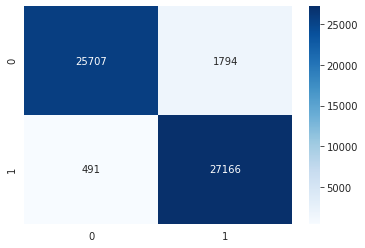

In [35]:
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), cmap=plt.cm.Blues, annot=True, fmt='d')

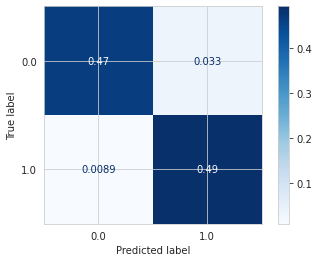

In [36]:
plot_confusion_matrix(model_xgb, x_test, y_test, normalize='all', cmap=plt.cm.Blues)

accuracy 점수는 0.8598027484680373
auc 값은 0.8597840394873826
Kappa 값은 0.7195933907341139
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.86     27501
         1.0       0.86      0.87      0.86     27657

    accuracy                           0.86     55158
   macro avg       0.86      0.86      0.86     55158
weighted avg       0.86      0.86      0.86     55158



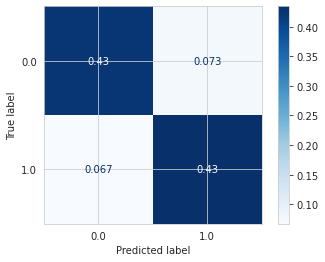

In [42]:
model_lgb = lgb.LGBMClassifier(max_depth=100, n_jobs=-1)
model_lgb.fit(x_train, y_train)
y_pred_lgb = model_lgb.predict(x_test)
print(f'accuracy 점수는', accuracy_score(y_test, y_pred_lgb))
print(f'auc 값은', roc_auc_score(y_test, y_pred_lgb))
print(f'Kappa 값은', cohen_kappa_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))
plot_confusion_matrix(model_lgb, x_test, y_test, normalize='all', cmap=plt.cm.Blues)

In [ ]:
param_rf = {'n_estimators':np.arange(100,200,50)}
grid_rf = GridSearchCV(model_xgb, param_grid=param_rf, scoring='accuracy', cv=5 )
grid_rf.fit(x_train, y_train)
## GridSearch는 시간이 너무 걸리는 관계로 이번 커널은 안한다.

KeyboardInterrupt: ignored

In [33]:
def Model(Model):
  Model.fit(x_train, y_train)
  y_pred = Model.predict(x_test)
  print(f'accuracy 점수는', accuracy_score(y_test, y_pred))
  print(f'auc 값은', roc_auc_score(y_test, y_pred))
  print(f'Kappa 값은', cohen_kappa_score(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  plot_confusion_matrix(Model, x_test, y_test, normalize='all', cmap=plt.cm.Blues)

accuracy 점수는 0.9456501359332521
auc 값은 0.9478407068050886
Kappa 값은 0.8903833095582386
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     23879
         1.0       0.92      0.97      0.94     18789

    accuracy                           0.95     42668
   macro avg       0.94      0.95      0.95     42668
weighted avg       0.95      0.95      0.95     42668



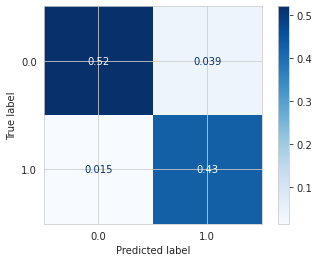

In [ ]:
Model(xgb.XGBClassifier(max_depth=100, n_jobs=-1))

accuracy 점수는 0.9552592106496672
auc 값은 0.9570099146523112
Kappa 값은 0.9096596572393857
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96     23879
         1.0       0.93      0.97      0.95     18789

    accuracy                           0.96     42668
   macro avg       0.95      0.96      0.95     42668
weighted avg       0.96      0.96      0.96     42668



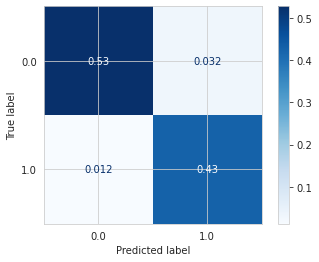

In [ ]:
Model(RandomForestClassifier(max_depth=100, n_jobs=-1))

accuracy 점수는 0.8774960157495079
auc 값은 0.8780560382921746
Kappa 값은 0.7526071455314042
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89     23879
         1.0       0.85      0.88      0.86     18789

    accuracy                           0.88     42668
   macro avg       0.88      0.88      0.88     42668
weighted avg       0.88      0.88      0.88     42668



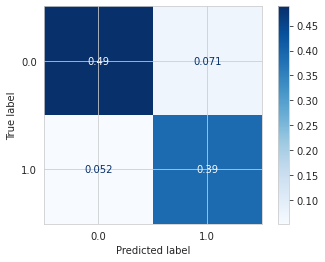

In [ ]:
Model(DecisionTreeClassifier(max_depth=100))

Text(0.5, 1.0, 'Feature Importaces of RandomForest')

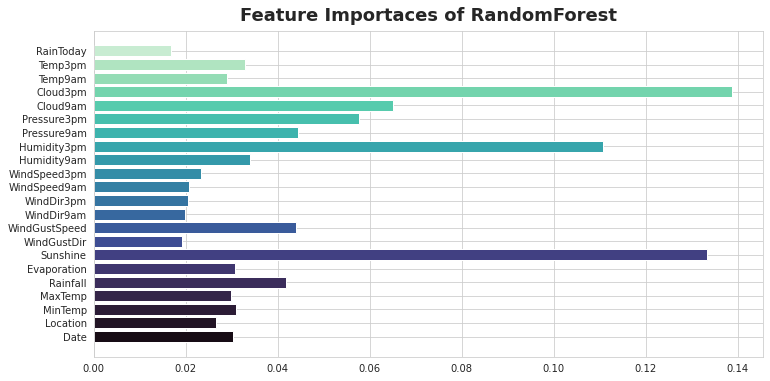

In [37]:
plt.subplots(figsize=(12,6))
plt.barh(x.columns, model_rf.feature_importances_, color=sns.color_palette('mako', n_colors=len(x.columns)))
plt.title('Feature Importaces of RandomForest', fontsize=18, fontweight='bold', pad=10)

Text(0.5, 1.0, 'Feature Importaces of XGBoost')

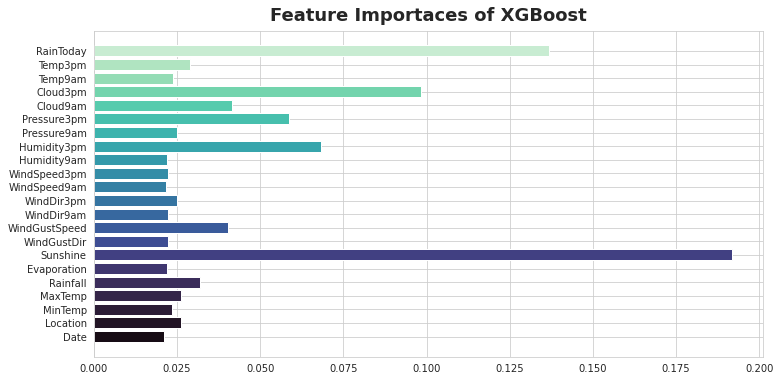

In [38]:
plt.subplots(figsize=(12,6))
plt.barh(x.columns, model_xgb.feature_importances_, color=sns.color_palette('mako', n_colors=len(x.columns)))
plt.title('Feature Importaces of XGBoost', fontsize=18, fontweight='bold', pad=10)

Text(0.5, 1.0, 'Feature Importaces of DecisionTree')

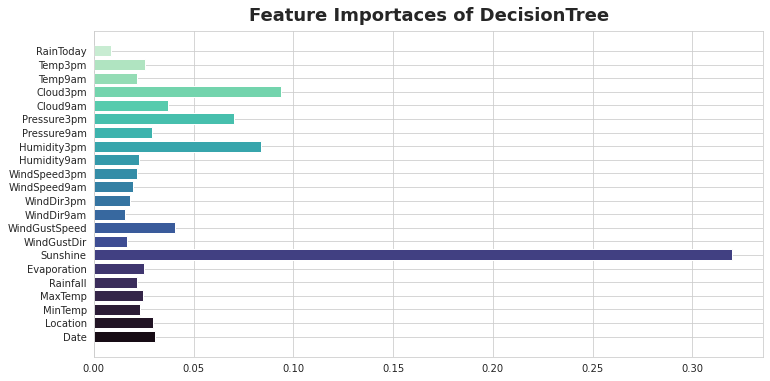

In [31]:
plt.subplots(figsize=(12,6))
plt.barh(x.columns, model_dectree.feature_importances_, color=sns.color_palette('mako', n_colors=len(x.columns)))
plt.title('Feature Importaces of DecisionTree', fontsize=18, fontweight='bold', pad=10)